Data Loaded.

--- Processing Season 1 ---
  Running Model A (Optimization)...
  Running Model B (Bayesian MAP)...


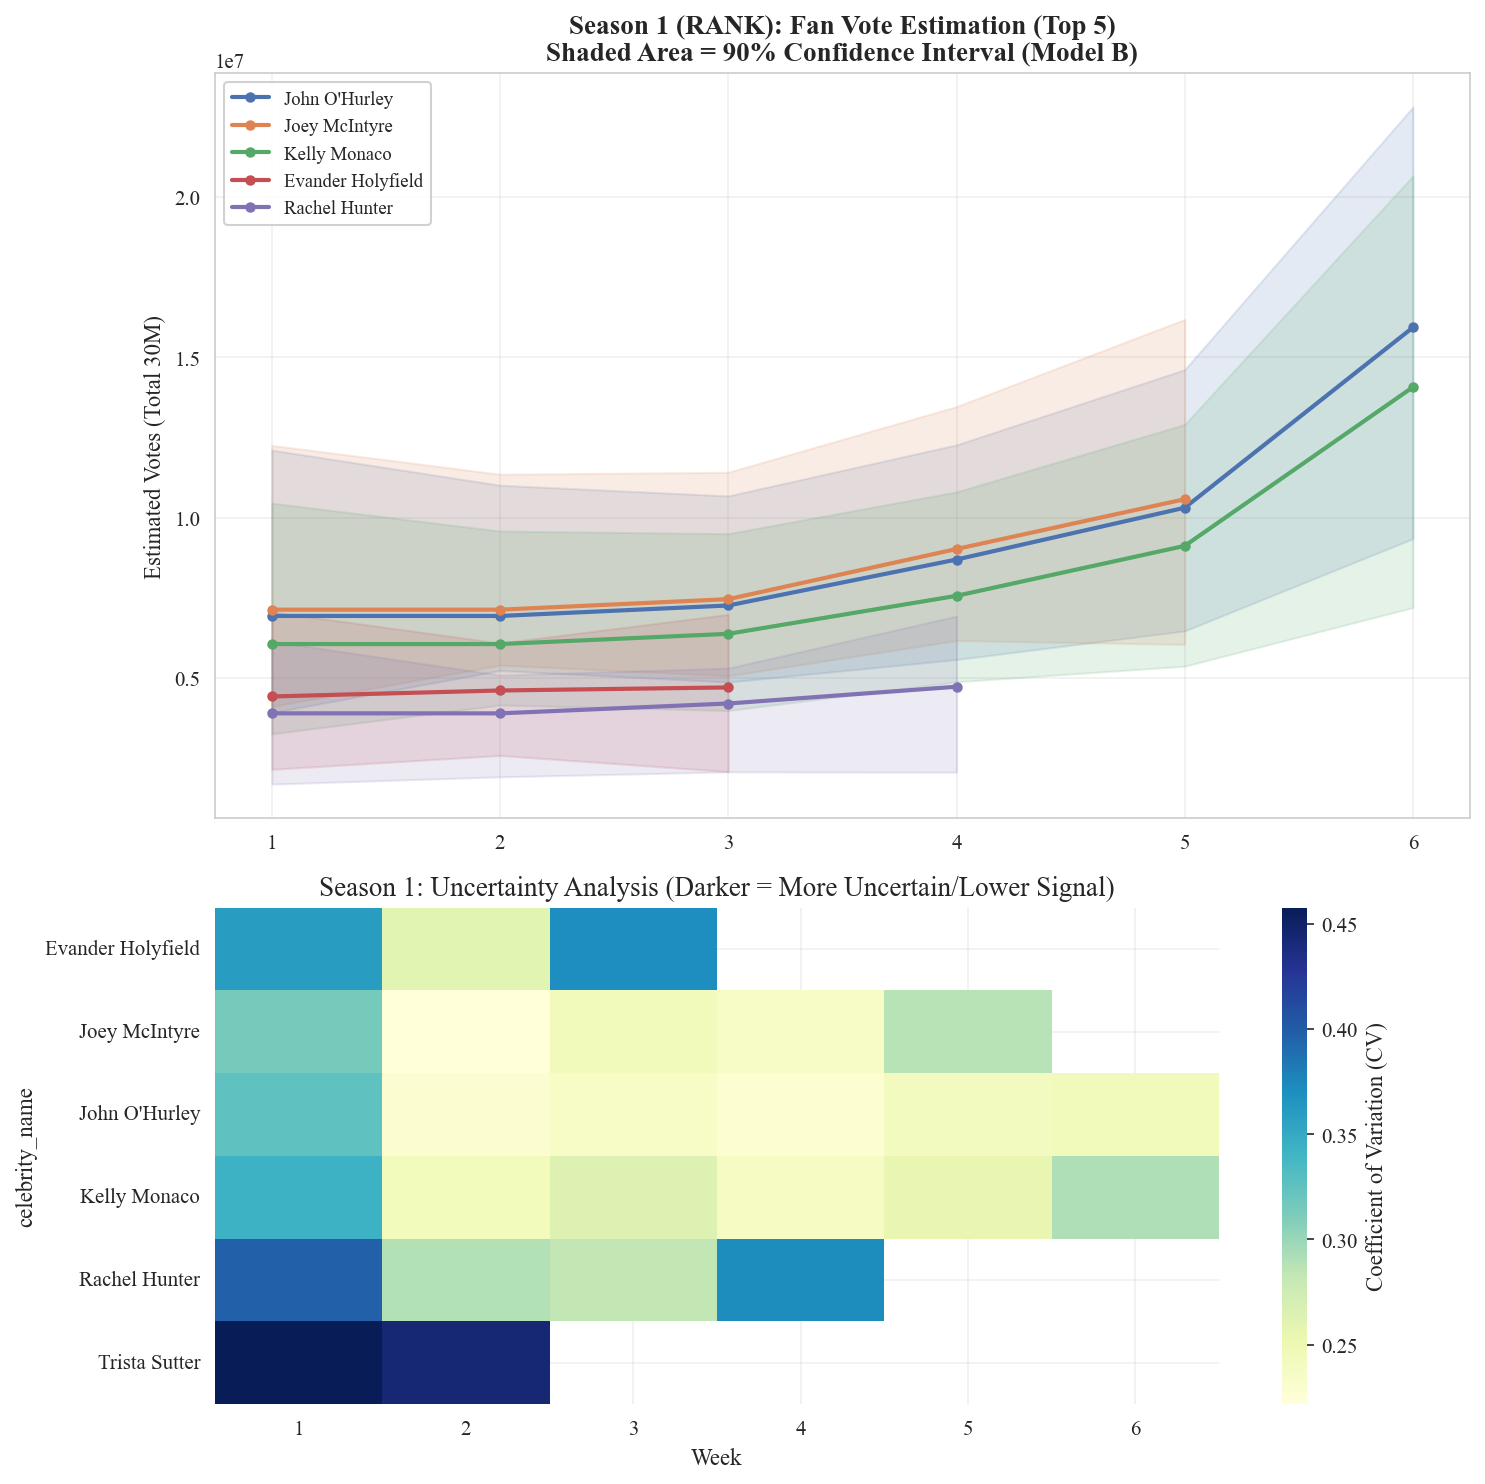


--- Processing Season 21 ---
  Running Model A (Optimization)...
  Running Model B (Bayesian MAP)...


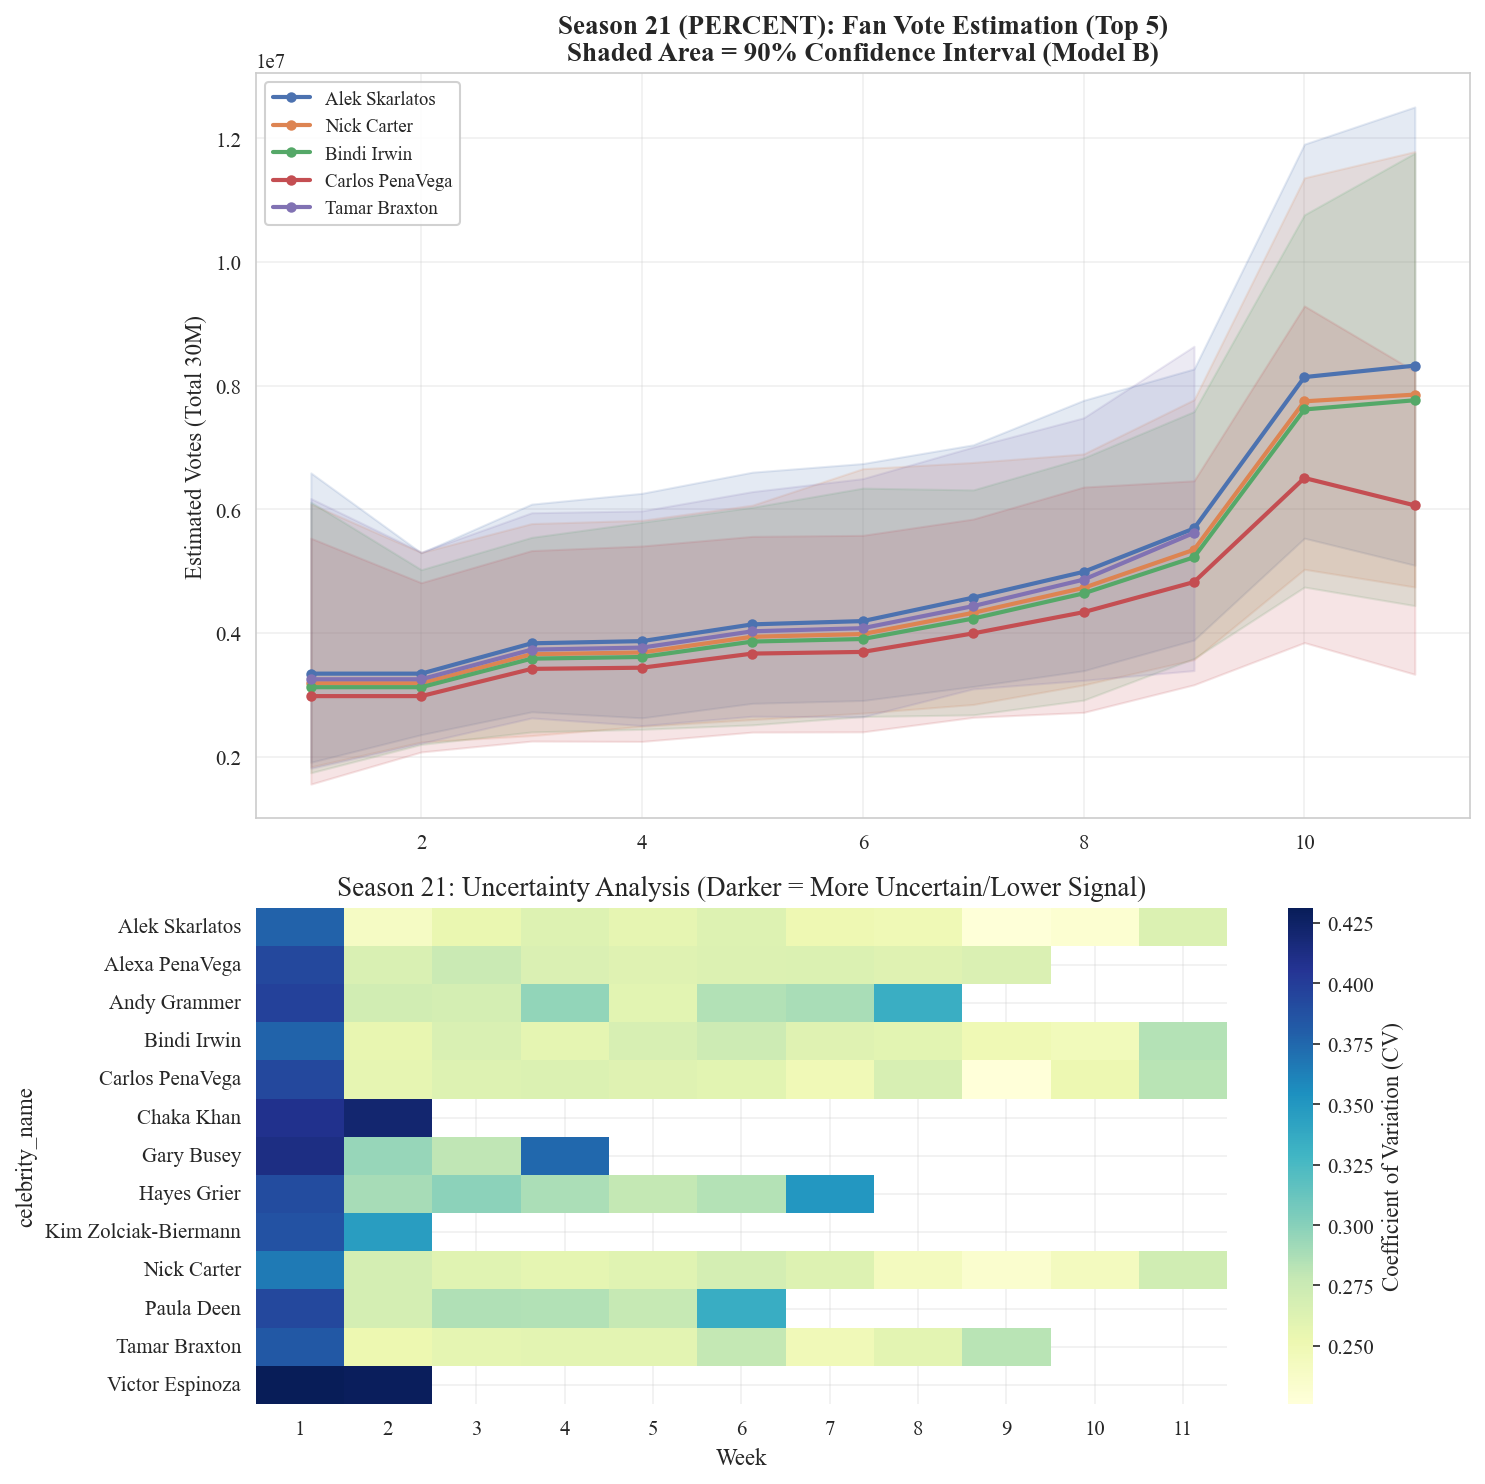


--- Processing Season 33 ---
  Running Model A (Optimization)...
  Running Model B (Bayesian MAP)...


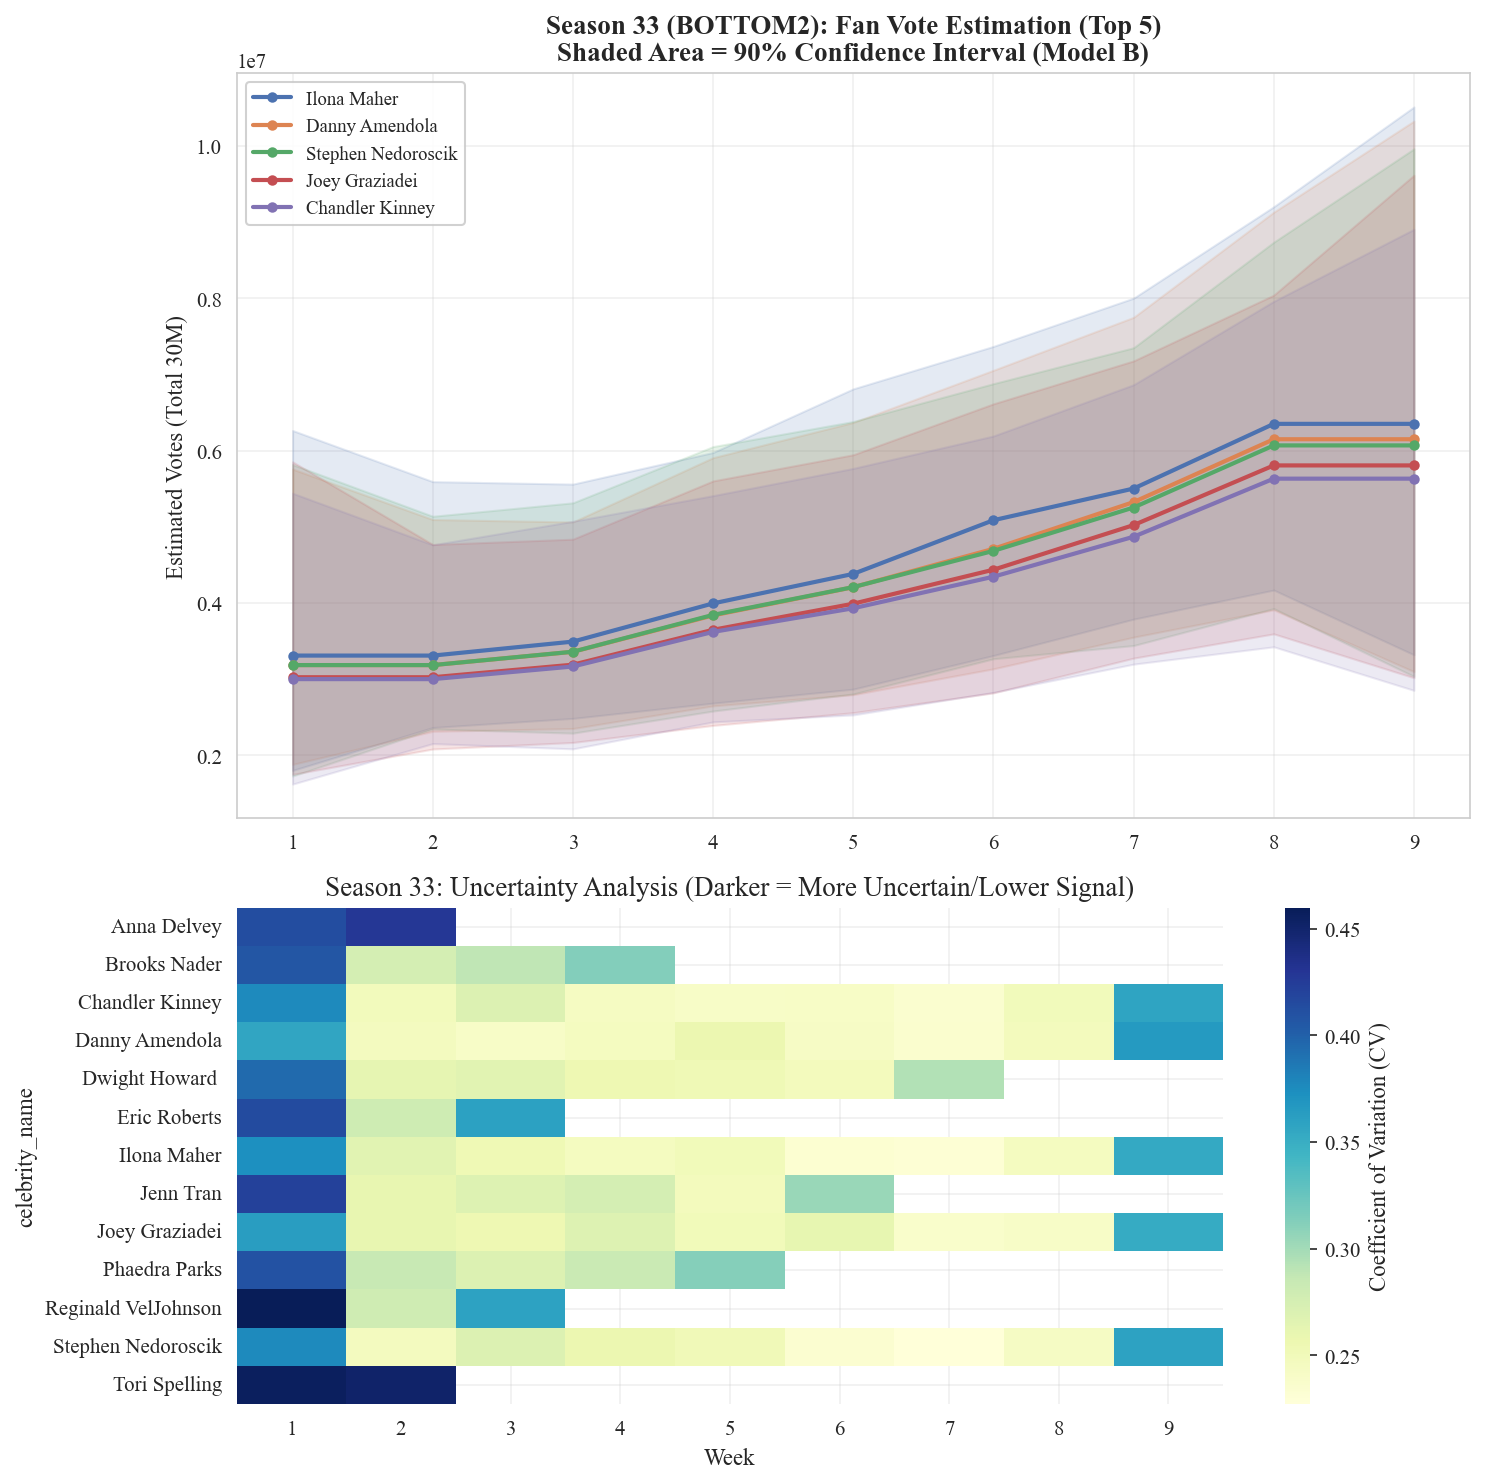


=== Evaluation Metrics ===
 season    rule  hit_rate  avg_margin
      1    RANK  0.666667    1.000000
     21 PERCENT  1.000000    0.031830
     33 BOTTOM2  1.000000    1.833333

Running Overfitting Check (Entropy Analysis)...

=== Overfitting Check Table (Entropy Analysis) ===
 Season  Weeks Analyzed  Avg Entropy  Min Entropy  Volatility (Std)
      1               6       0.9764       0.9473            0.0222
     21              11       0.9861       0.9666            0.0102
     33               9       0.9878       0.9648            0.0133


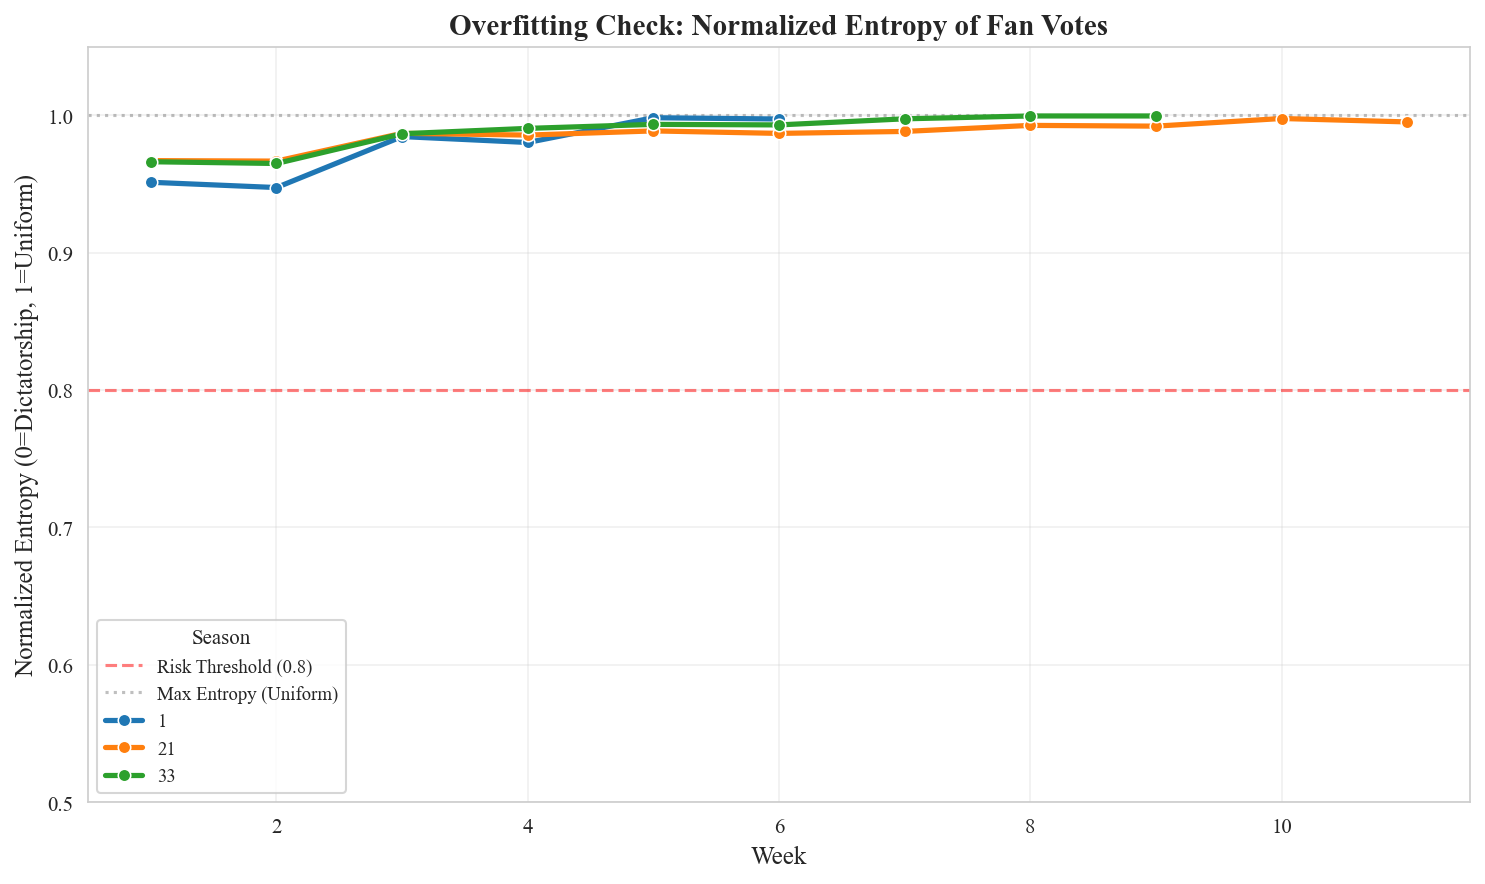

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata, entropy
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings

# 忽略一些数值计算的警告
warnings.filterwarnings('ignore')

# -----------------------
# 全局常量
# -----------------------
TOTAL_VOTES = 30_000_000  # 假设每周 3000 万票
SEED = 2026

# -----------------------
# 0) 数据结构与预处理
# -----------------------

@dataclass
class WeekEvent:
    season: int
    week: int
    rule: str               # "RANK", "PERCENT", "BOTTOM2"
    active_names: List[str] # 当周参赛选手
    eliminated: List[str]   # 当周淘汰者
    j_scores: np.ndarray    # 评委原始分
    j_percent: np.ndarray   # 评委分占比
    j_rank: np.ndarray      # 评委排名 (1=Best, N=Worst) - 注意：DWTS通常分数高排名好(1)
    k_elim: int             # 淘汰人数
    is_z_week: bool         # 是否无淘汰周

def get_season_rule(season: int) -> str:
    if season <= 2: return "RANK"
    elif season <= 27: return "PERCENT"
    else: return "BOTTOM2"  # S28-34 引入Bottom2 + 评委救人

def calculate_ranks_desc(scores: np.ndarray) -> np.ndarray:
    """
    计算排名：分数越高，排名越小(1)。
    例如分数 [30, 29, 28] -> 排名 [1, 2, 3]
    """
    # 负号实现降序排名
    return rankdata(-scores, method='min')

def load_data(csv_path: str, target_seasons: List[int]) -> Tuple[pd.DataFrame, Dict[Tuple[int, int], WeekEvent]]:
    df = pd.read_csv(csv_path)
    
    # 转长表
    week_cols = [c for c in df.columns if "week" in c and "judge" in c]
    long_df = df.melt(
        id_vars=["season", "celebrity_name", "results"],
        value_vars=week_cols,
        var_name="wk_str", value_name="score"
    )
    long_df["week"] = long_df["wk_str"].str.extract(r"week(\d+)_").astype(int)
    long_df["score"] = pd.to_numeric(long_df["score"], errors="coerce")
    
    # 聚合每周总分
    wk_tot = long_df.groupby(["season", "week", "celebrity_name", "results"])["score"].sum(min_count=1).reset_index()
    
    # 标记 Active (分数 > 0)
    wk_tot = wk_tot[wk_tot["score"].fillna(0) > 0].copy()
    
    # 解析淘汰周
    def parse_elim(res, wk):
        if pd.isna(res): return False
        if "Eliminated Week" in str(res):
            try:
                elim_w = int(str(res).split("Week ")[1])
                return elim_w == wk
            except: return False
        if str(res) == "Withdrew": 
            # 退赛通常在当周结算前或后，这里简化处理：若当周有分且结果是Withdrew，视为当周离开
            return False 
        return False

    wk_tot["is_elim"] = wk_tot.apply(lambda x: parse_elim(x["results"], x["week"]), axis=1)

    events = {}
    for (s, w), g in wk_tot.groupby(["season", "week"]):
        if s not in target_seasons: continue
        
        names = g["celebrity_name"].tolist()
        scores = g["score"].values
        elim_names = g[g["is_elim"]]["celebrity_name"].tolist()
        
        # 计算评委指标
        j_sum = scores.sum()
        j_percent = scores / j_sum if j_sum > 0 else np.zeros_like(scores)
        j_rank = calculate_ranks_desc(scores)
        
        rule = get_season_rule(s)
        
        events[(s, w)] = WeekEvent(
            season=s, week=w, rule=rule,
            active_names=names,
            eliminated=elim_names,
            j_scores=scores,
            j_percent=j_percent,
            j_rank=j_rank,
            k_elim=len(elim_names),
            is_z_week=(len(elim_names) == 0)
        )
        
    return wk_tot, events

# -----------------------
# 1) 模型 A：优化 (Max Entropy + Smoothing)
# -----------------------
def estimate_model_a(season_events: List[WeekEvent], smooth_lambda=50.0) -> pd.DataFrame:
    """
    非贝叶斯基线：每一周求解一个凸优化问题。
    """
    season_events.sort(key=lambda x: x.week)
    results = []
    v_prev = None # 上一周的票份额
    
    for ev in season_events:
        n = len(ev.active_names)
        
        # 初始猜测：均匀分布 或 延续上一周
        x0 = np.ones(n) / n
        if v_prev is not None:
            # 简单映射上一周的人到这一周（处理淘汰导致的人员变化）
            # 这里简化处理：直接均匀，或者如果需要更精细，可以匹配名字
            pass 

        # 目标函数：平滑项 + 负熵
        # minimize: lambda * ||v - v_prev||^2 + sum(v log v)
        def obj_func(v):
            # 熵正则 (Max Entropy -> Min Neg Entropy)
            ent = np.sum(v * np.log(v + 1e-9))
            # 平滑正则 (如果上一周存在)
            # 这里为了代码简洁，仅做 L2 Regularization towards uniform (weak prior)
            # 若要严格跨周平滑，需要对齐名字，较为繁琐，Task 1中用 Model B 做主力的平滑
            reg = np.sum((v - 1/n)**2) 
            return ent + smooth_lambda * reg

        # 约束1: Sum = 1
        cons = [{'type': 'eq', 'fun': lambda v: np.sum(v) - 1.0}]
        
        # 约束2: 淘汰不等式 (Hard Constraint)
        # 即便在 Rank 赛季，我们用 Percent 作为连续代理：
        # Survivor Vote% + Judge% >= Eliminated Vote% + Judge%
        if ev.k_elim > 0:
            elim_indices = [i for i, name in enumerate(ev.active_names) if name in ev.eliminated]
            safe_indices = [i for i, name in enumerate(ev.active_names) if name not in ev.eliminated]
            
            for ei in elim_indices:
                for si in safe_indices:
                    # 我们希望 Safe 总分 > Elim 总分
                    # J_s + v_s >= J_e + v_e  --> v_s - v_e + (J_s - J_e) >= 0
                    diff_j = ev.j_percent[si] - ev.j_percent[ei]
                    cons.append({'type': 'ineq', 'fun': lambda v, si=si, ei=ei, dj=diff_j: v[si] - v[ei] + dj})

        bounds = [(1e-4, 1.0) for _ in range(n)]
        
        res = minimize(obj_func, x0, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter': 200})
        
        v_hat = res.x / res.x.sum()
        
        for i, name in enumerate(ev.active_names):
            results.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_A": v_hat[i],
                "model_a_success": res.success
            })
            
    return pd.DataFrame(results)

# -----------------------
# 2) 模型 B：贝叶斯 MAP + 采样
# -----------------------
def estimate_model_b(season_events: List[WeekEvent], 
                     sigma_rw=0.5, kappa=40.0, n_samples=500) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    贝叶斯推断：
    1. 潜变量 u_{i,t} (Logit)
    2. Prior: u_{i,t} ~ N(u_{i,t-1}, sigma^2) [Random Walk]
    3. Likelihood: P(Safe > Elim) = Sigmoid(Difference)
    """
    season_events.sort(key=lambda x: x.week)
    
    # 1. 构建参数索引
    param_map = [] # (week_idx, name) -> global_param_idx
    unique_keys = []
    
    for ev in season_events:
        for name in ev.active_names:
            unique_keys.append((ev.week, name))
    
    # 去重并保留顺序
    unique_keys = list(dict.fromkeys(unique_keys))
    key_to_idx = {k: i for i, k in enumerate(unique_keys)}
    n_params = len(unique_keys)
    
    # 辅助函数
    def get_indices(ev):
        return [key_to_idx[(ev.week, n)] for n in ev.active_names]

    def softmax(u):
        e = np.exp(u - np.max(u))
        return e / np.sum(e)

    # 2. 定义负对数后验
    def neg_log_posterior(u_vec):
        loss = 0.0
        
        # A. Prior: Random Walk (跨周平滑)
        # 找到每个选手的时间序列
        player_dict = {}
        for (wk, name), idx in key_to_idx.items():
            player_dict.setdefault(name, []).append((wk, idx))
            
        for name, seq in player_dict.items():
            seq.sort()
            for k in range(len(seq) - 1):
                w1, idx1 = seq[k]
                w2, idx2 = seq[k+1]
                # 只有相邻周才施加 RW 约束 (处理 Z 周的关键：跨越 Z 周连接)
                if w2 == w1 + 1:
                    loss += 0.5 * ((u_vec[idx2] - u_vec[idx1]) / sigma_rw) ** 2
        
        # B. Likelihood: 淘汰约束
        for ev in season_events:
            if ev.k_elim == 0: continue # Z周无似然贡献，全靠 Prior 连接
            
            idxs = get_indices(ev)
            current_u = u_vec[idxs]
            v_share = softmax(current_u)
            
            elim_idxs = [i for i, n in enumerate(ev.active_names) if n in ev.eliminated]
            safe_idxs = [i for i, n in enumerate(ev.active_names) if n not in ev.eliminated]
            
            if not elim_idxs: continue
            
            # 使用 Sigmoid 软约束: Safe的总分应高于 Elim
            # Score = J_percent + v_share (这里做通用近似，哪怕是Rank制，Percent高通常Rank也好)
            for ei in elim_idxs:
                score_e = ev.j_percent[ei] + v_share[ei]
                for si in safe_idxs:
                    score_s = ev.j_percent[si] + v_share[si]
                    diff = score_s - score_e
                    # 损失 = -log(sigmoid(kappa * diff))
                    loss += np.log(1 + np.exp(-kappa * diff))
        
        # L2 Regularization (防止 drift)
        loss += 1e-4 * np.sum(u_vec**2)
        return loss

    # 3. 求解 MAP
    u0 = np.zeros(n_params)
    res = minimize(neg_log_posterior, u0, method='L-BFGS-B', options={'maxiter': 1000})
    u_map = res.x
    
    # 4. 拉普拉斯近似 (Hessian -> Covariance) 用于采样
    # 简化的对角 Hessian 估计
    h = 1e-3
    hess_diag = []
    base_loss = neg_log_posterior(u_map)
    for i in range(n_params):
        u_p = u_map.copy(); u_p[i] += h
        u_m = u_map.copy(); u_m[i] -= h
        l_p = neg_log_posterior(u_p)
        l_m = neg_log_posterior(u_m)
        d2 = max((l_p + l_m - 2*base_loss)/(h**2), 1e-2)
        hess_diag.append(d2)
    
    std_vec = 1.0 / np.sqrt(np.array(hess_diag))
    
    # 5. 采样
    rng = np.random.default_rng(SEED)
    samples = rng.normal(u_map, std_vec, size=(n_samples, n_params))
    
    # 6. 整理结果
    map_rows = []
    unc_rows = []
    
    for ev in season_events:
        idxs = get_indices(ev)
        
        # MAP
        v_map_val = softmax(u_map[idxs])
        
        # Uncertainty
        v_samples_block = np.array([softmax(row[idxs]) for row in samples]) # (N_samples, n_players)
        
        for i, name in enumerate(ev.active_names):
            map_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_B": v_map_val[i]
            })
            
            # 统计指标
            mean_v = np.mean(v_samples_block[:, i])
            std_v = np.std(v_samples_block[:, i])
            low_v = np.percentile(v_samples_block[:, i], 5)
            high_v = np.percentile(v_samples_block[:, i], 95)
            
            # 熵 (衡量该选手的分布不确定性，或者该周整体的熵)
            # 这里计算 CV
            cv = std_v / (mean_v + 1e-9)
            
            unc_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "mean_share": mean_v, "std_share": std_v, 
                "low_share": low_v, "high_share": high_v,
                "cv": cv
            })
            
    return pd.DataFrame(map_rows), pd.DataFrame(unc_rows)

# -----------------------
# 3) 集成与评估
# -----------------------
def evaluate_metrics(events: Dict, df_ens: pd.DataFrame) -> pd.DataFrame:
    metrics = []
    seasons = df_ens["season"].unique()
    
    for s in seasons:
        s_evs = [e for k, e in events.items() if k[0] == s]
        s_evs.sort(key=lambda x: x.week)
        
        hits = 0
        total_elim_weeks = 0
        margins = []
        
        for ev in s_evs:
            if ev.k_elim == 0: continue # Z周不计入Hit Rate
            
            total_elim_weeks += 1
            sub = df_ens[(df_ens["season"] == s) & (df_ens["week"] == ev.week)]
            if sub.empty: continue
            
            # 对齐数据
            name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
            v_share = np.array([name_map.get(n, 0) for n in ev.active_names])
            
            # --- 核心：根据赛制计算合并结果 ---
            if ev.rule == "PERCENT":
                # 越低越危险
                combined = ev.j_percent + v_share
                rank_combined = calculate_ranks_desc(combined) # 1=Best
                # 倒数 k_elim 名
                # argsort default is ascending. combined small -> index at 0.
                sorted_idx = np.argsort(combined) 
                bottom_k_names = [ev.active_names[i] for i in sorted_idx[:ev.k_elim]]
                
                # Margin: Safe_Min - Elim_Max (正数表示安全)
                if len(sorted_idx) > ev.k_elim:
                    score_elim_best = combined[sorted_idx[ev.k_elim-1]]
                    score_safe_worst = combined[sorted_idx[ev.k_elim]]
                    margins.append(score_safe_worst - score_elim_best)
                
                hit = set(ev.eliminated).issubset(set(bottom_k_names))

            elif ev.rule in ["RANK", "BOTTOM2"]:
                # Rank Sum: 越高越危险 (Rank 1 is best)
                v_rank = calculate_ranks_desc(v_share)
                combined_rank_sum = ev.j_rank + v_rank
                
                # Sort descending (Large sum = Bad)
                sorted_idx = np.argsort(-combined_rank_sum)
                
                if ev.rule == "RANK": # S1-2
                    bottom_k_names = [ev.active_names[i] for i in sorted_idx[:ev.k_elim]]
                    hit = set(ev.eliminated).issubset(set(bottom_k_names))
                    if len(sorted_idx) > ev.k_elim:
                        # Margin in Rank Sum units
                        bad_score = combined_rank_sum[sorted_idx[ev.k_elim-1]]
                        good_score = combined_rank_sum[sorted_idx[ev.k_elim]]
                        margins.append(bad_score - good_score) # Should be positive if separated
                        
                elif ev.rule == "BOTTOM2":
                # 按照 Rank Sum 排序 (数值越大越差)
                # 假设 k_elim 是本周实际走的人数（通常为1），但 Bottom区通常是 2人
                # 我们要看的是：倒数第2名(Bottom区) 和 倒数第3名(安全区) 的差距
    
                # 1. 找到该周定义的 Bottom 数量，S28+通常是 Bottom 2
                    n_bottom = 2 
    
                # 防止人不够的情况（比如决赛圈）
                    if len(sorted_idx) > n_bottom:
                        idx_danger = sorted_idx[n_bottom - 1] # Bottom 2 里较好的那个（Rank Sum 较小）
                        idx_safe   = sorted_idx[n_bottom]     # 安全区里最差的那个（Rank Sum 较大? 不，Rank Sum 是越大越差）
        
                    # 修正逻辑：
                    # sorted_idx 是按 -combined_rank_sum 降序排列 (第0个是最大的sum，即最差)
                    # 所以 sorted_idx[0] 是倒数第一，sorted_idx[1] 是倒数第二 (Bottom 2边界)
                    # sorted_idx[2] 是倒数第三 (安全)
        
                        score_danger = combined_rank_sum[sorted_idx[n_bottom - 1]] # 倒数第二的分数
                        score_safe   = combined_rank_sum[sorted_idx[n_bottom]]     # 倒数第三的分数
        
                    # Margin = 倒数第二(危险) - 倒数第三(安全)
                    # 因为 RankSum 越大越差，理论上 score_danger > score_safe
                    # 我们希望 Margin 正数表示 "Bottom 2 和安全区有明显界限"
                        margins.append(score_danger - score_safe)
                    else:
                        margins.append(0)

    # Hit Rate 逻辑保持不变：只要实际淘汰者在 predicted Bottom 2 里就算对

            hits += int(hit)
            
        metrics.append({
            "season": s,
            "rule": s_evs[0].rule if s_evs else "N/A",
            "hit_rate": hits / total_elim_weeks if total_elim_weeks > 0 else 0,
            "avg_margin": np.mean(margins) if margins else 0
        })
        
    return pd.DataFrame(metrics)

# -----------------------
# 4) 可视化 (SCI Style)
# -----------------------
def init_sci_style():
    sns.set_style("whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "SimSun"],
        "axes.labelsize": 11,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 9,
        "figure.dpi": 150,
        "axes.grid": True,
        "grid.alpha": 0.3
    })

def plot_season_analysis(season, df_ens, df_unc, events):
    init_sci_style()
    s_df = df_ens[df_ens["season"] == season]
    u_df = df_unc[df_unc["season"] == season]
    
    if s_df.empty: return

    # 获取 Top 5 选手
    top_names = s_df.groupby("celebrity_name")["votes_ens"].mean().nlargest(5).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1.5, 1]})
    
    # 子图1：票数趋势与置信区间
    ax = axes[0]
    colors = sns.color_palette("deep", n_colors=len(top_names))
    
    for i, name in enumerate(top_names):
        d = s_df[s_df["celebrity_name"] == name]
        u = u_df[u_df["celebrity_name"] == name]
        
        # 转换回总票数
        v_mean = d["votes_ens"].values
        v_high = u["high_share"].values * TOTAL_VOTES
        v_low = u["low_share"].values * TOTAL_VOTES
        weeks = d["week"].values
        
        ax.plot(weeks, v_mean, label=name, color=colors[i], linewidth=2, marker='o', markersize=4)
        ax.fill_between(weeks, v_low, v_high, color=colors[i], alpha=0.15)
    
    rule = get_season_rule(season)
    ax.set_title(f"Season {season} ({rule}): Fan Vote Estimation (Top 5)\nShaded Area = 90% Confidence Interval (Model B)", fontweight='bold')
    ax.set_ylabel("Estimated Votes (Total 30M)")
    ax.legend(loc='upper left', frameon=True, framealpha=0.9)
    
    # 子图2：不确定性 (CV) 热力图
    ax2 = axes[1]
    piv = u_df.pivot(index="celebrity_name", columns="week", values="cv")
    sns.heatmap(piv, ax=ax2, cmap="YlGnBu", cbar_kws={'label': 'Coefficient of Variation (CV)'})
    ax2.set_title(f"Season {season}: Uncertainty Analysis (Darker = More Uncertain/Lower Signal)")
    ax2.set_xlabel("Week")
    
    plt.tight_layout()
    plt.show()

def analyze_entropy_overfitting(df_ens: pd.DataFrame):
    """
    计算每周粉丝投票分布的熵，用于检测过拟合。
    Normalized Entropy = H(p) / ln(N)
    范围 [0, 1]。越接近 1 表示分布越均匀（自然/保守）；越接近 0 表示越极端（过拟合风险）。
    """
    entropy_records = []
    
    # 按赛季和周分组
    groups = df_ens.groupby(['season', 'week'])
    
    for (s, w), g in groups:
        votes = g['vote_share_ens'].values
        # 归一化：确保和为1
        votes = votes / np.sum(votes)
        n = len(votes)
        
        if n <= 1: continue # 只有1个人无法计算熵
        
        # 1. 计算香农熵 (Shannon Entropy)
        # H = -sum(p * log(p))
        ent = entropy(votes)
        
        # 2. 计算最大可能熵 (Max Entropy for N candidates)
        # H_max = ln(N)
        max_ent = np.log(n)
        
        # 3. 归一化熵 (Normalized Entropy)
        norm_ent = ent / max_ent
        
        entropy_records.append({
            "season": s,
            "week": w,
            "n_candidates": n,
            "shannon_entropy": ent,
            "normalized_entropy": norm_ent
        })
        
    return pd.DataFrame(entropy_records)

def plot_entropy_check(entropy_df: pd.DataFrame):
    """
    绘制熵变化图 (Overfitting Check Visualization)
    """
    plt.figure(figsize=(10, 6))
    
    # 绘制安全阈值线 (例如 0.8)
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Risk Threshold (0.8)')
    plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Max Entropy (Uniform)')
    
    sns.lineplot(
        data=entropy_df, 
        x='week', 
        y='normalized_entropy', 
        hue='season', 
        palette='tab10',
        marker='o',
        linewidth=2.5
    )
    
    plt.title('Overfitting Check: Normalized Entropy of Fan Votes', fontsize=14, fontweight='bold')
    plt.ylabel('Normalized Entropy (0=Dictatorship, 1=Uniform)', fontsize=12)
    plt.xlabel('Week', fontsize=12)
    plt.ylim(0.5, 1.05) # 通常不会低于0.5，设置下限让图好看点
    plt.legend(title='Season', loc='lower left')
    plt.tight_layout()
    plt.show()

def generate_entropy_table(entropy_df: pd.DataFrame):
    """
    生成用于论文的统计表格
    """
    # 聚合统计
    summary = entropy_df.groupby('season')['normalized_entropy'].agg(
        ['count', 'mean', 'min', 'std']
    ).reset_index()
    
    summary.columns = ['Season', 'Weeks Analyzed', 'Avg Entropy', 'Min Entropy', 'Volatility (Std)']
    
    # 格式化
    summary['Avg Entropy'] = summary['Avg Entropy'].round(4)
    summary['Min Entropy'] = summary['Min Entropy'].round(4)
    summary['Volatility (Std)'] = summary['Volatility (Std)'].round(4)
    
    print("\n=== Overfitting Check Table (Entropy Analysis) ===")
    print(summary.to_string(index=False))
    return summary


# -----------------------
# 主程序
# -----------------------
if __name__ == "__main__":
    # 1. 准备数据
    csv_path = "2026_MCM_Problem_C_Data.csv"
    # 选取典型的三个赛季：S2(Rank Strict), S21(Percent), S30(Rank Bottom2)
    target_seasons = [1, 21, 33] 
    
    try:
        wk_tot, events = load_data(csv_path, target_seasons)
        print("Data Loaded.")
        
        all_ens = []
        all_unc = []
        
        for s in target_seasons:
            print(f"\n--- Processing Season {s} ---")
            s_events = [e for k, e in events.items() if k[0] == s]
            if not s_events: continue
            
            # 2. 运行模型 A (Baseline)
            print("  Running Model A (Optimization)...")
            df_a = estimate_model_a(s_events, smooth_lambda=20.0)
            
            # 3. 运行模型 B (Bayesian MAP)
            print("  Running Model B (Bayesian MAP)...")
            df_b, df_unc_s = estimate_model_b(s_events, sigma_rw=0.4, kappa=50.0)
            
            # 4. 集成 (Ensemble)
            # 假设 B 模型在捕捉动态上更好，给 70% 权重
            df_merge = pd.merge(df_a, df_b, on=["season", "week", "celebrity_name"])
            w_b = 0.7
            df_merge["vote_share_ens"] = w_b * df_merge["vote_share_B"] + (1 - w_b) * df_merge["vote_share_A"]
            df_merge["votes_ens"] = df_merge["vote_share_ens"] * TOTAL_VOTES
            
            all_ens.append(df_merge)
            all_unc.append(df_unc_s)
            
            # 5. 单季绘图
            plot_season_analysis(s, df_merge, df_unc_s, events)
            
        # 6. 总体评估
        final_ens = pd.concat(all_ens)
        metrics = evaluate_metrics(events, final_ens)
        
        print("\n=== Evaluation Metrics ===")
        print(metrics.to_string(index=False))
        
        # 解释：
        # Hit Rate: 模型预测的“最差选手”包含实际淘汰者的比例
        # Avg Margin: 实际淘汰者与安全线的分差 (正数表示符合常理，即Safe>Elim)

        # === 新增：过拟合检验 ===
        print("\nRunning Overfitting Check (Entropy Analysis)...")
    
        # 1. 计算
        entropy_df = analyze_entropy_overfitting(final_ens)
    
        # 2. 打印表格 (可直接复制到论文)
        entropy_summary = generate_entropy_table(entropy_df)
    
        # 3. 绘图 (可保存为论文插图)
        plot_entropy_check(entropy_df)
        
    except FileNotFoundError:
        print("Error: CSV not found.")
    except Exception as e:
        print(f"An error occurred: {e}")